### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data_utils

from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, plot_confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
DATA_FILE = 'lyrics.csv'
DATA_DIR = 'data'
MODELS_DIR = 'models'

MAX_N_WORDS = 128
MAX_FEATURES = 5000

In [4]:
class EpochLogger(CallbackAny2Vec):
    """Callback to log information about training"""
    
    def __init__(self):
        pass

    
w2v = Word2Vec.load(os.path.join(MODELS_DIR, 'w2v.model'))
# w2v.init_sims(replace=True)

df = pd.read_pickle(os.path.join(DATA_DIR, 'lyrics_df.pkl'))
df.drop(df[df.genre == 'Not Available'].index, axis=0, inplace=True)

First we will prepare the data for training - we split the data into train and test, crop lyrics to the the required length and pad them if needed, and convert each lyrics to a one hot, 2d representation using CountVectorizor

In [5]:
def clip_lyrics(row, n_words):
    return row.clean_lyrics[:n_words]


def lyrics_to_embedding(row, n_words, n_features, count_vect):
    
    embedding = count_vect.transform(row).toarray().argmax(axis=1)
    
    n_vects = embedding.shape[0]
    if n_vects < n_words:
        embedding = np.append(embedding, 
                              np.zeros(n_words - n_vects, dtype=int),
                              axis=0)
    return embedding


In [6]:

# df = df.iloc[idx].copy()
df['genre_code'] = df.genre.astype('category').cat.codes
df['cropped_lyrics'] = df.apply(clip_lyrics, args=(MAX_N_WORDS,), axis=1)
genres_codes = df[['genre', 'genre_code']].drop_duplicates().set_index('genre_code').sort_index().squeeze()


X_train, X_test, y_train, y_test = train_test_split(df.cropped_lyrics, 
                                                    df.genre_code, 
                                                    test_size=0.2, random_state=42)


In [7]:
%%time
vocab = w2v.wv.index2word[:MAX_FEATURES]
count_vect = CountVectorizer(vocabulary=vocab).fit(X_train.str.join(' '))

CPU times: user 10.2 s, sys: 100 ms, total: 10.3 s
Wall time: 10.3 s


In [8]:
%%time
X_train = X_train.apply(lyrics_to_embedding, args=(MAX_N_WORDS, MAX_FEATURES, count_vect))
X_test = X_test.apply(lyrics_to_embedding, args=(MAX_N_WORDS, MAX_FEATURES, count_vect))

CPU times: user 3min 17s, sys: 59.3 ms, total: 3min 17s
Wall time: 3min 17s


X_train we convert the processed data into dataloaders to be used for our model.

In [9]:
batch_size = 32

train_target = torch.tensor(y_train.values).long()
train = torch.tensor(np.stack(X_train.values)).long()
train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset=train_tensor, batch_size=batch_size, shuffle=True)

test_target = torch.tensor(y_test.values).long()
test = torch.tensor(np.stack(X_test.values)).long()
test_tensor = data_utils.TensorDataset(test, test_target) 
test_loader = data_utils.DataLoader(dataset=test_tensor, batch_size=batch_size, shuffle=True)

We define our model - the model will receive as input a 2d, one hot representation of the lyrics, as a sequence, and will make use of the word2vec embeddings, allowing them to change during training.

In [10]:
def train_loop(epoch, log_interval=500):
    model.train()  # set training mode
#     lr = 5e-5
    print(lr)
    iteration = 1
    for ep in range(1, epoch+1):
#         if ep % 10==0:
#             print(f'decreasing learning rate from {lr} to {lr/2}\n')
#             lr /= 2
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
        start = time.time()
        
        for batch_idx, (X, target) in enumerate(train_loader, start=1):
            # bring data to the computing device, e.g. GPU
            X, target = X.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            if (iteration % log_interval) == 0:
                print(f'Epoch:{ep:>2}/{epoch}\tBatch:{batch_idx:>5}/{len(train_loader)}',
                      f'Samples:{batch_idx * len(X):>6}/{len(train_loader.dataset):<6} ({100 * batch_idx // len(train_loader):<3}%)', 
                      f'\tLoss: {loss.item():.3f}\tElapsed Time: {time.time()-start:.2f}s')
        
            iteration += 1
            
        test(plot_cm=(ep == epoch)) # evaluate at the end of epoch
        print(f'{"="*50} \nElapsed time: {time.time()-start:.2f}s\n')
        
def test(plot_cm=False):
    model.eval()  # set evaluation mode
    test_loss = 0
    correct = 0
    total = 0
    predictions = []
    confusion_matrix = torch.zeros(model.n_labels, model.n_labels)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.max(1)[1] # get the index of the max log-probability
            
            correct += (pred == target).sum().item()
            total += target.size(0)
            for t, p in zip(target, pred):
                confusion_matrix[t, p] += 1
    
    test_loss /= len(test_loader)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    if plot_cm:
        
        class_correct = confusion_matrix.diag()
        class_total = confusion_matrix.sum(1)
        class_accuracies = 100 * class_correct / class_total
        
        for code, label in genres_codes.items():
            confusion_matrix[code] = confusion_matrix[code] / confusion_matrix[code].sum()
            print(f'Accuracy for {label}: {class_accuracies[code]:.3f}%')
        
        print(f'\nMean per class accuracy: {class_accuracies.mean():.3f}%')

        # Plot confusion matrix
        f = plt.figure()
        ax = f.add_subplot(111)
        cax = ax.imshow(confusion_matrix.numpy(), interpolation='nearest', cmap=plt.cm.Blues)
        f.colorbar(cax)
        plt.xticks(range(genres_codes.size), genres_codes.to_list(), rotation=90)
        plt.yticks(range(genres_codes.size), genres_codes.to_list())

    

In [11]:

class ConvNet(nn.Module):
    def __init__(self, n_labels, initial_weights=None, freeze_weights=False,
                 in_channels=1, out_channels=100, 
                 kernels=[3,4,5], padding=0, stride=1, 
                 keep_probab = 0.5,
                ):
        super(ConvNet, self).__init__()
        
        self.n_labels = n_labels
        self.allow_grad = True
        
        if initial_weights is None:
            raise NotImplementedError('Random Initialization Not Implemented Yet')
        else:
            self.init_weights = torch.tensor(initial_weights, dtype=torch.float)
            self.allow_grad = not freeze_weights
            vocab_size, embedding_length = initial_weights.shape

        
        self.kernels = np.asarray(kernels)
                
        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        self.word_embeddings.weight = nn.Parameter(self.init_weights, requires_grad=True)
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, 
                               kernel_size=(kernels[0], embedding_length), 
                               stride=embedding_length, 
                               )
        
        self.conv2 = nn.Conv2d(in_channels, out_channels, 
                               kernel_size=(kernels[1], embedding_length), 
                               stride=embedding_length, 
                               )
        
        self.conv3 = nn.Conv2d(in_channels, out_channels, 
                               kernel_size=(kernels[2], embedding_length), 
                               stride=embedding_length, 
                               )
        
        self.dropout = nn.Dropout(p=keep_probab)
        self.label = nn.Linear(len(kernels)*out_channels, n_labels)
        
    def _conv_block(self, x, conv_layer):
        conv_out = conv_layer(x)  # conv_out.size() = (batch_size, out_channels, dim, 1)
        activation = F.relu(conv_out.squeeze(3))  # activation.size() = (batch_size, out_channels, dim1)
        max_out = F.max_pool1d(activation, activation.size()[2]).squeeze(2)  # maxpool_out.size() = (batch_size, out_channels)
        return max_out

    def forward(self, x):
    
        x = self.word_embeddings(x)
        out = x.unsqueeze(1)
        max_out1 = self._conv_block(out, self.conv1)
        max_out2 = self._conv_block(out, self.conv2)
        max_out3 = self._conv_block(out, self.conv3)

        all_out = torch.cat((max_out1, max_out2, max_out3), 1)
        all_out = all_out.view(all_out.size(0), -1)
        fc_in = self.dropout(all_out)
        
        scores = self.label(fc_in)
        
#         scores = F.softmax(scores, dim=1)
        return scores
        


In [12]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(42)
if use_cuda:
    torch.cuda.manual_seed(42)
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [13]:
output_size = np.unique(y_train).size
bow_vocab = count_vect.vocabulary  

model = ConvNet(initial_weights=w2v.wv[bow_vocab], n_labels=output_size).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

weights = torch.Tensor(y_train.value_counts().max() / y_train.value_counts().sort_index()).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

In [14]:
torch.Tensor(y_train.value_counts().max() / y_train.value_counts().sort_index())

tensor([ 7.4922, 14.1662, 51.1544,  4.3104, 34.2876, 13.5466,  4.6881, 20.5281,
         2.6576, 30.9370,  1.0000])

0.0001
Epoch: 1/5	Batch:  500/5955 Samples: 16000/190551 (8  %) 	Loss: 2.237	Elapsed Time: 1.58s
Epoch: 1/5	Batch: 1000/5955 Samples: 32000/190551 (16 %) 	Loss: 2.063	Elapsed Time: 3.16s
Epoch: 1/5	Batch: 1500/5955 Samples: 48000/190551 (25 %) 	Loss: 2.223	Elapsed Time: 4.68s
Epoch: 1/5	Batch: 2000/5955 Samples: 64000/190551 (33 %) 	Loss: 2.092	Elapsed Time: 6.20s
Epoch: 1/5	Batch: 2500/5955 Samples: 80000/190551 (41 %) 	Loss: 2.167	Elapsed Time: 7.71s
Epoch: 1/5	Batch: 3000/5955 Samples: 96000/190551 (50 %) 	Loss: 2.255	Elapsed Time: 9.21s
Epoch: 1/5	Batch: 3500/5955 Samples:112000/190551 (58 %) 	Loss: 2.440	Elapsed Time: 10.74s
Epoch: 1/5	Batch: 4000/5955 Samples:128000/190551 (67 %) 	Loss: 1.965	Elapsed Time: 12.27s
Epoch: 1/5	Batch: 4500/5955 Samples:144000/190551 (75 %) 	Loss: 2.191	Elapsed Time: 13.80s
Epoch: 1/5	Batch: 5000/5955 Samples:160000/190551 (83 %) 	Loss: 2.177	Elapsed Time: 15.33s
Epoch: 1/5	Batch: 5500/5955 Samples:176000/190551 (92 %) 	Loss: 2.374	Elapsed Time: 16.87

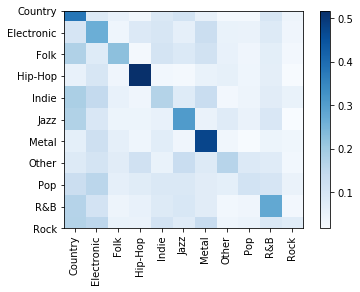

In [17]:
N_EPOCHS = 5
lr = 1e-4
t0 = time.time()
train_loop(N_EPOCHS)
print(f'Training completed!!!\nTotal training time: {time.time() - t0}')

Unfortunatly, we were unable to create an efficient architecture for training, and much more tunning of the network is needed.